In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import math

In [2]:
# Load the CSV you saved
df = pd.read_csv("test_with_predictions.csv")

# generate the 78 (x,y) names
pairs = [f"({x},{y})" for x in range(3, 15) for y in range(x+1, 16)]
assert len(pairs) == 78

# split old names
first_78 = df.columns[:78]   # old first 78 (will be replaced)
rest = df.columns[78:]       # keep rest as is (TRUE, predicted, etc.)

# combine new names
new_names = pairs + list(rest)

# apply renaming
df.columns = new_names
df.head()


,"(3,4)","(3,5)","(3,6)","(3,7)","(3,8)","(3,9)","(3,10)","(3,11)","(3,12)","(3,13)",...,"(11,14)","(11,15)","(12,13)","(12,14)","(12,15)","(13,14)","(13,15)","(14,15)",True,Predicted
0,0.527766,0.487581,0.633045,1.018741,1.491912,1.825220,1.895933,2.162376,2.253780,2.389547,...,2.499434,2.565722,2.031104,2.422041,2.549872,2.723208,2.727168,2.712707,0.6,0.595645
1,1.090657,0.314481,0.687345,1.907808,0.955274,0.420235,0.174251,0.096155,0.020044,-0.013431,...,-0.334601,-0.353786,-0.182853,-0.265933,-0.312148,-0.353549,-0.381345,-0.410005,0.3,0.301898
2,-0.301527,-1.087717,-1.402304,-1.812299,-1.936725,-1.829974,-1.641362,-1.496742,-1.383568,-1.280124,...,-0.338138,-0.354364,-0.164796,-0.277257,-0.317552,-0.403710,-0.403269,-0.399974,0.8,0.746530
3,0.055333,0.280180,0.831000,1.511523,0.963406,0.630933,0.360172,0.228576,0.161499,0.110589,...,-0.305369,-0.327349,-0.205735,-0.302268,-0.334276,-0.404711,-0.401218,-0.394500,0.6,0.600155
4,-0.066158,-0.517247,-0.381165,-0.436811,-0.028209,0.302322,0.465205,1.289788,0.473602,0.299766,...,-2.009395,-1.677687,-0.745507,-0.730921,-0.658398,-0.641733,-0.544593,-0.431406,0.1,0.100079


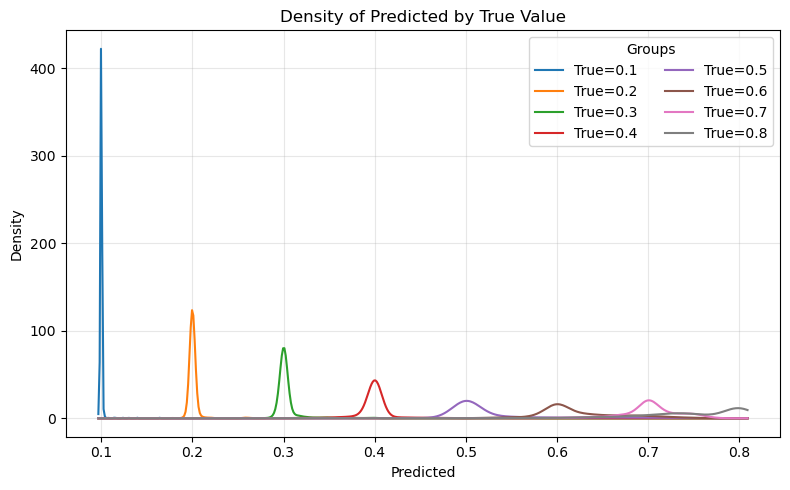

In [3]:

true_levels = sorted(df["True"].unique())   # should be [0.1,...,0.8]

# x-grid for KDE
x_min = df["Predicted"].min()
x_max = df["Predicted"].max()
x = np.linspace(x_min, x_max, 500)

plt.figure(figsize=(8,5))
for t in true_levels:
    vals = df.loc[df["True"] == t, "Predicted"].values
    if len(vals) > 1:  # KDE needs >1 point
        kde = gaussian_kde(vals)
        plt.plot(x, kde(x), label=f"True={t}")
plt.xlabel("Predicted")
plt.ylabel("Density")
plt.title("Density of Predicted by True Value")
plt.legend(title="Groups", ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

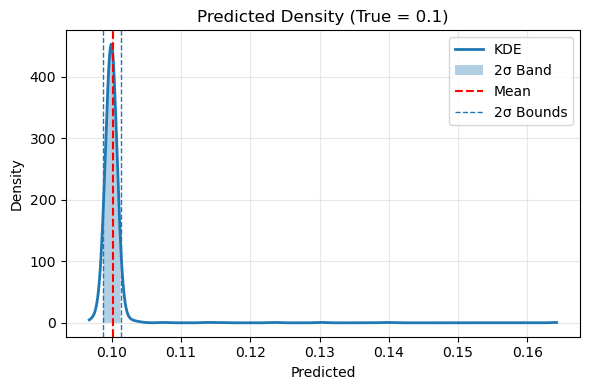

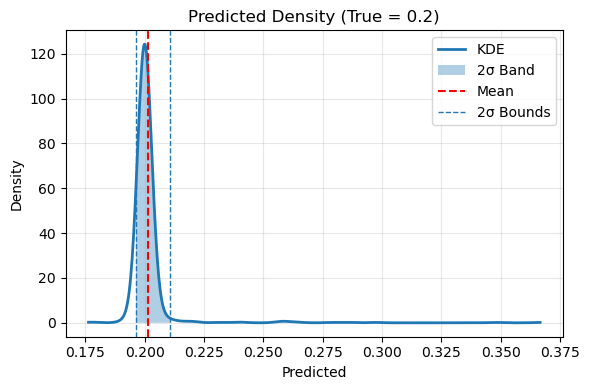

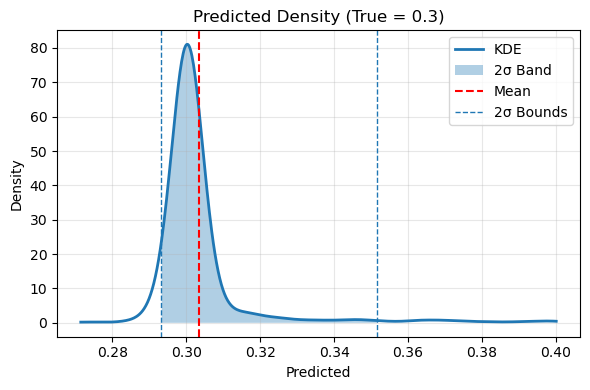

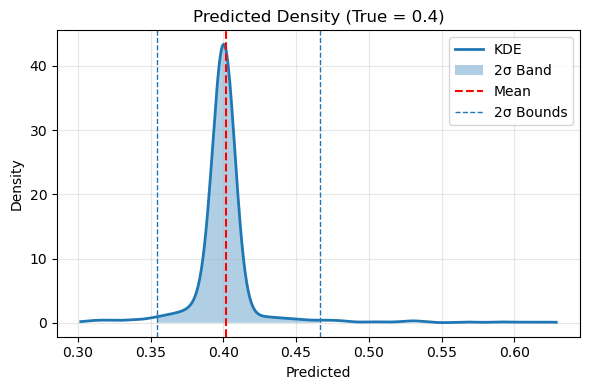

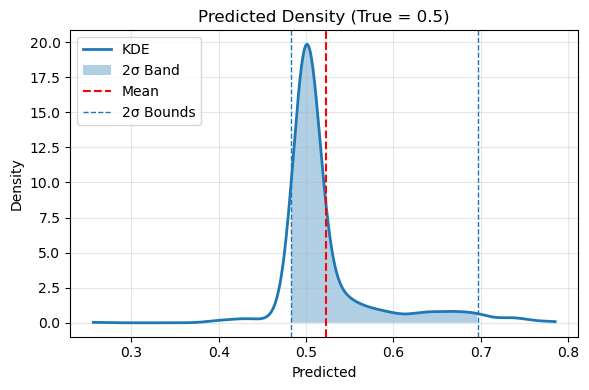

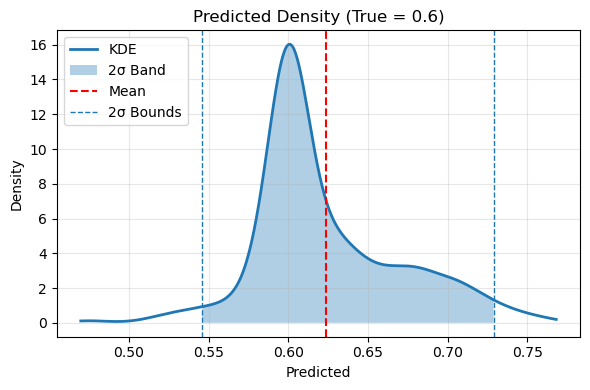

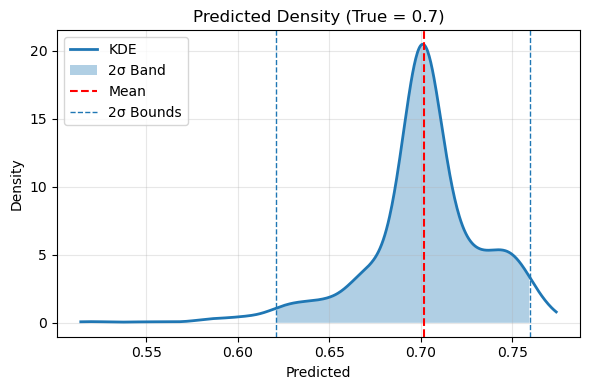

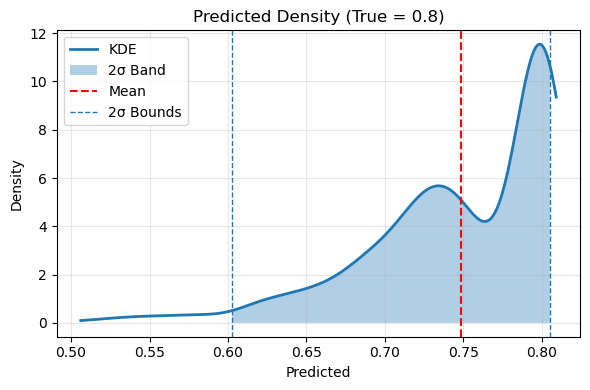

In [6]:
for t in true_levels:
    vals = df.loc[df["True"] == t, "Predicted"].values
    if len(vals) < 2:
        continue

    # --- 95% CI band (2.5% to 97.5%)
    lower, upper = np.percentile(vals, [2.5, 97.5])
    mu = np.mean(vals)

    # KDE grid
    x = np.linspace(vals.min(), vals.max(), 600)
    kde = gaussian_kde(vals)
    y = kde(x)

    # Mask for shading between lower & upper
    mask = (x >= lower) & (x <= upper)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(x, y, lw=2, label="KDE")
    plt.fill_between(x[mask], y[mask], alpha=0.35, label="2σ Band")

    # Guide lines
    plt.axvline(mu, color="red", linestyle="--", lw=1.5, label="Mean")
    plt.axvline(lower, linestyle="--", lw=1.0, label="2σ Bounds")
    plt.axvline(upper, linestyle="--", lw=1.0)

    plt.title(f"Predicted Density (True = {t})")
    plt.xlabel("Predicted")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"density_true_{t}_with_sigma_band.png", dpi=300)
    plt.show()

In [8]:
best_dict = {}

for t in true_levels:
    vals = df.loc[df["True"] == t, "Predicted"].values
    lower, upper = np.percentile(vals, [2.5, 97.5])  # or mean ± std
    
    subset = df.loc[
        (df["True"] == t) &
        (df["Predicted"] >= lower) &
        (df["Predicted"] <= upper)
    ]
    
    best_dict[t] = subset
    print(f"True={t} → {len(subset)} test samples (in {lower:.3f}–{upper:.3f})")

True=0.1 → 909 test samples (in 0.099–0.101)
True=0.2 → 847 test samples (in 0.196–0.211)
True=0.3 → 831 test samples (in 0.293–0.352)
True=0.4 → 830 test samples (in 0.355–0.467)
True=0.5 → 862 test samples (in 0.482–0.697)
True=0.6 → 814 test samples (in 0.546–0.729)
True=0.7 → 844 test samples (in 0.621–0.759)
True=0.8 → 897 test samples (in 0.602–0.806)


In [9]:
best_rows_1 = best_dict[0.1]   # DataFrame of 909 rows (features pairs + True + Predicted)

In [10]:
best_rows_2 = best_dict[0.2]   # DataFrame of 847 rows (features pairs + True + Predicted)

In [11]:
best_rows_3 = best_dict[0.3]   # DataFrame of 831 rows (features pairs + True + Predicted)

In [12]:
best_rows_4 = best_dict[0.4]   # DataFrame of 830 rows (features pairs + True + Predicted)

In [13]:
best_rows_5 = best_dict[0.5]   # DataFrame of 862 rows (features pairs + True + Predicted)

In [14]:
best_rows_6 = best_dict[0.6]   # DataFrame of 814 rows (features pairs + True + Predicted)

In [15]:
best_rows_7 = best_dict[0.7]   # DataFrame of 844 rows (features pairs + True + Predicted)

In [16]:
best_rows_8 = best_dict[0.8]   # DataFrame of 897 rows (features pairs + True + Predicted)

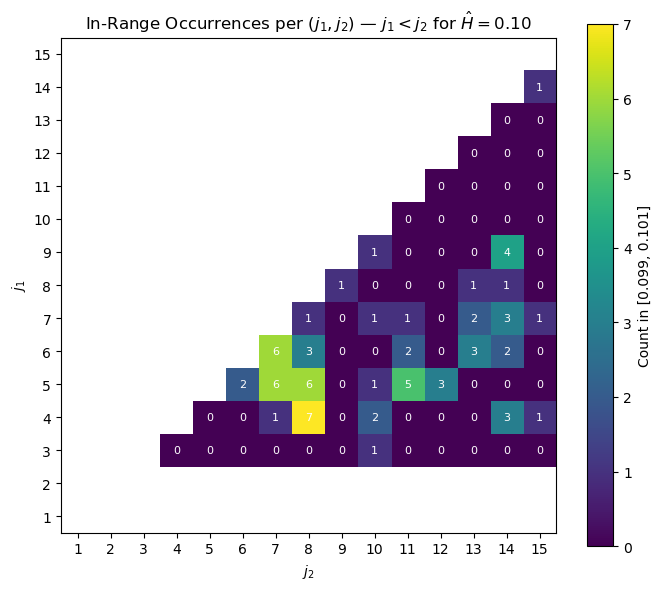

In [17]:
lower1, upper1 = 0.099, 0.101

pair_cols = list(best_rows_1.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_1[col].between(lower1, upper1, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower1:.3f}, {upper1:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.10$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.show()

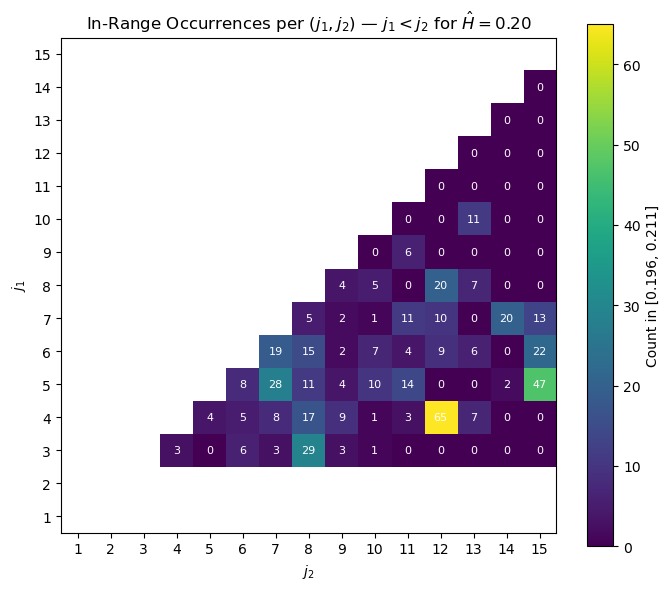

In [18]:
lower2, upper2 = 0.196, 0.211

pair_cols = list(best_rows_2.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_2[col].between(lower2, upper2, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower2:.3f}, {upper2:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.20$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.savefig("heatmap_H02.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

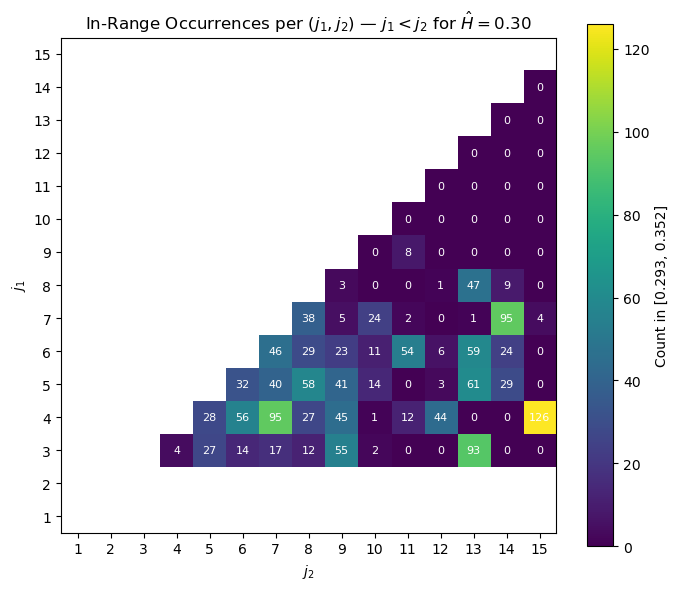

In [25]:
lower3, upper3 = 0.293, 0.352

pair_cols = list(best_rows_3.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_3[col].between(lower3, upper3, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower3:.3f}, {upper3:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.30$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.show()

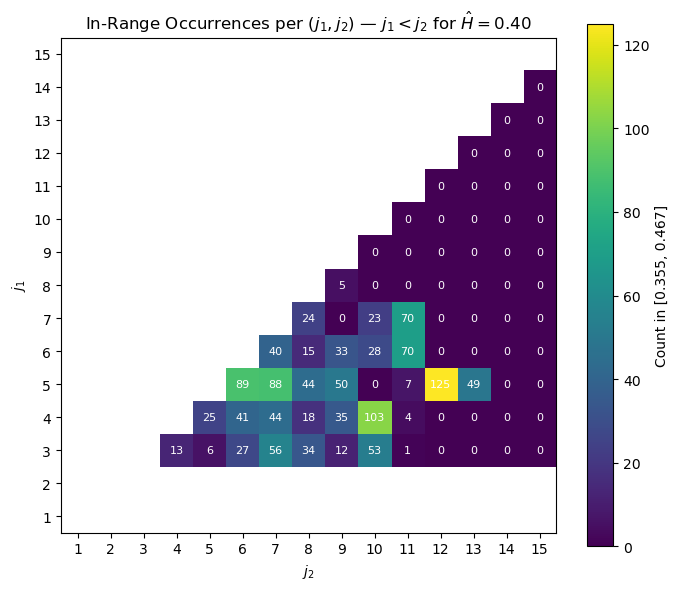

In [26]:
lower4, upper4 = 0.355, 0.467

pair_cols = list(best_rows_4.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_4[col].between(lower4, upper4, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower4:.3f}, {upper4:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.40$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.show()

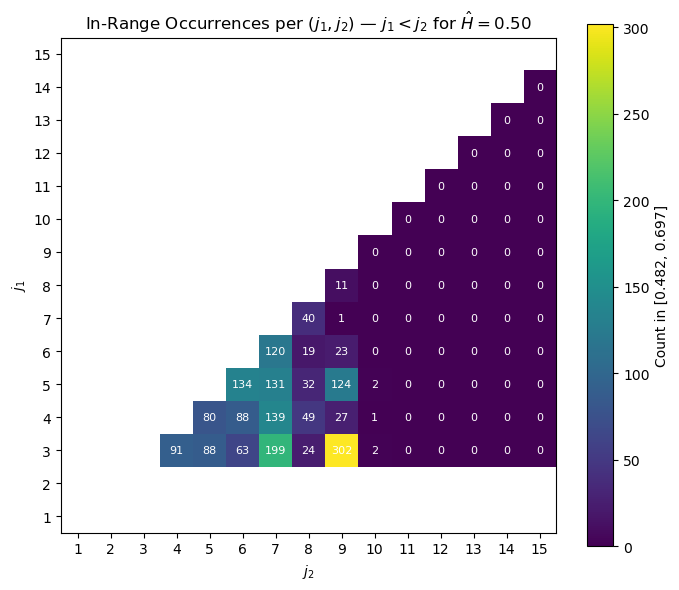

In [27]:
lower5, upper5 = 0.482, 0.697

pair_cols = list(best_rows_5.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_5[col].between(lower5, upper5, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower5:.3f}, {upper5:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.50$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.show()

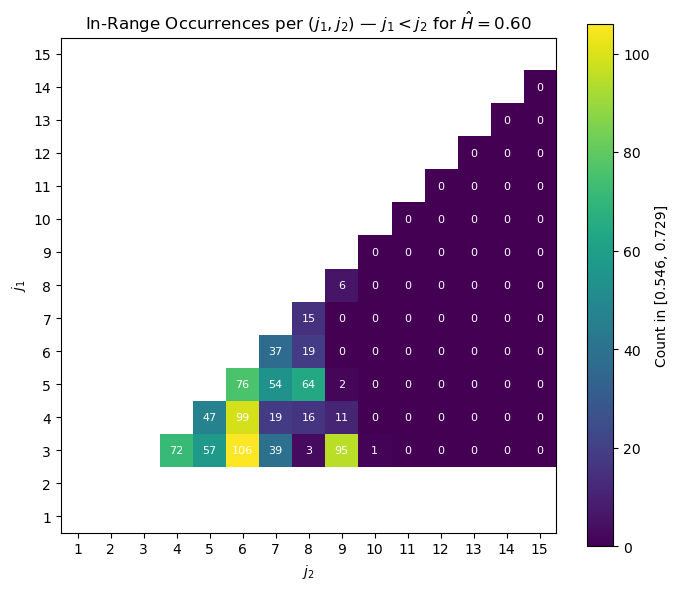

In [19]:
lower6, upper6 = 0.546, 0.729

pair_cols = list(best_rows_6.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_6[col].between(lower6, upper6, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower6:.3f}, {upper6:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.60$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.savefig("heatmap_H06.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


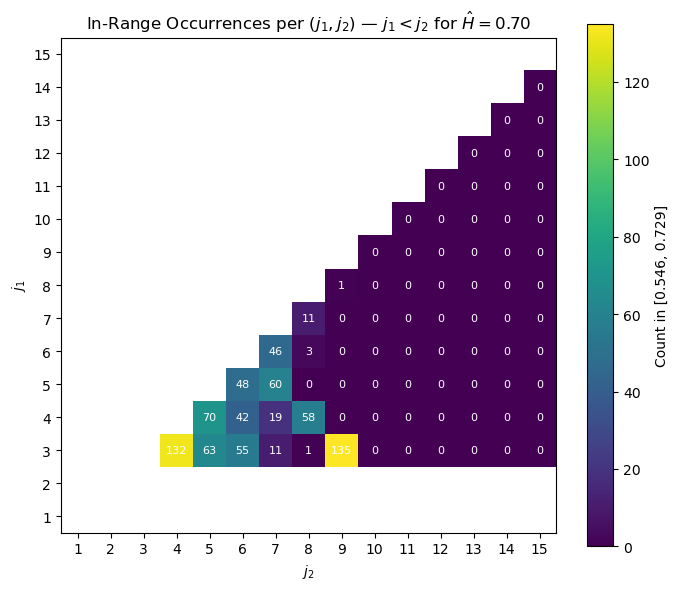

In [32]:
lower7, upper7 = 0.546, 0.729

pair_cols = list(best_rows_7.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_7[col].between(lower7, upper7, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower7:.3f}, {upper7:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.70$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.show()

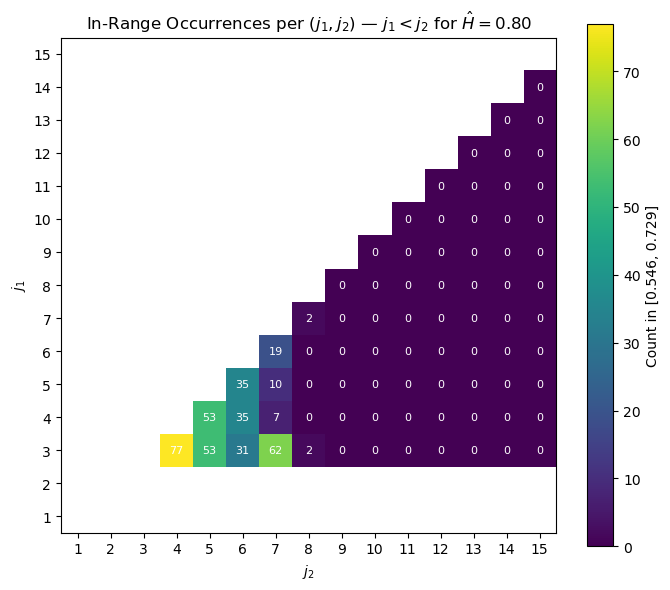

In [31]:
lower8, upper8 = 0.546, 0.729

pair_cols = list(best_rows_8.columns[:78])

# Count occurrences in range per (x,y)
counts = {}
for col in pair_cols:
    x_str, y_str = col.strip("()").split(",")
    x, y = int(x_str), int(y_str)
    in_range = best_rows_8[col].between(lower8, upper8, inclusive="both").sum()
    counts[(x, y)] = int(in_range)

# Build 15x15 grid with NaN (so hidden when masked)
heat = np.full((15, 15), np.nan)
for (x, y), c in counts.items():
    if 1 <= x <= 15 and 1 <= y <= 15:
        heat[x-1, y-1] = c

# >>> Do NOT replace NaN with 0; we want them masked/transparent
# heat = np.nan_to_num(heat, nan=0)  # <-- remove this

# Keep ONLY upper triangle (x < y), hide lower+diag and any NaNs
tri_keep = np.triu(np.ones_like(heat, dtype=bool), k=1)
mask = np.isnan(heat) | (~tri_keep)
heat_masked = np.ma.array(heat, mask=mask)

# Transparent for masked cells
cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)

plt.figure(figsize=(7, 6))
im = plt.imshow(
    heat_masked, origin="lower", aspect="equal", cmap=cmap,
    vmin=np.nanmin(heat), vmax=np.nanmax(heat)
)
plt.colorbar(im, label=f"Count in [{lower8:.3f}, {upper8:.3f}]")

# Ticks/labels (use 1..15; or see alternative below for 3..15)
plt.xticks(np.arange(15), np.arange(1, 16))
plt.yticks(np.arange(15), np.arange(1, 16))
plt.xlabel("$j_2$")
plt.ylabel("$j_1$")
plt.title(r"In-Range Occurrences per $(j_1, j_2)$ — $j_1<j_2$ for $\hat{H}=0.80$")

# Annotate only visible (unmasked) cells, white text
for i in range(15):
    for j in range(15):
        if not heat_masked.mask[i, j]:
            plt.text(j, i, str(int(heat[i, j])), ha="center", va="center",
                     fontsize=8, color="white")

plt.tight_layout()
plt.show()

In [13]:
best_rows_6.to_csv("best_rows_true_0.6_with_features.csv", index=False)